In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import create_KS_data

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [9]:
tf.test.gpu_device_name()

''

# KS System

In [21]:
# setting up params (and saving, if applicable)
from numpy import *

# simutlation paramaters
params_mat = np.array([
    [1.0, 1.0, 1.0],
    # [2.0, 2.0, 1.0]
])

t0 = 0.0
T = 200.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = True

numpoints_xgrid = 64
length = 40
xgrid = length*np.linspace(0, 1, numpoints_xgrid)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1])

# making ae save directory
dir_name_data = os.getcwd() + dir_sep + 'saved_data'
if not os.path.isdir(dir_name_data):
    os.makedirs(dir_name_data)

counter = 0
while True:
    dir_check = 'data_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_data + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_data = dir_name_data + dir_sep + dir_check
os.makedirs(dir_name_data+dir_sep+'plots')

# saving sim data
sim_data = {
    'params_mat':params_mat,
    'init_state':init_state,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'numpoints_xgrid':numpoints_xgrid,
    'length':length,
    'return_params_arr':return_params_arr,
    'normalize_flag':normalize_flag,
    'alldata_withparams_flag':alldata_withparams_flag,
    'prng_seed':prng_seed,
}
with open(dir_name_data+dir_sep+'sim_data_params.txt', 'w') as f:
    f.write(str(sim_data))

In [22]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [23]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

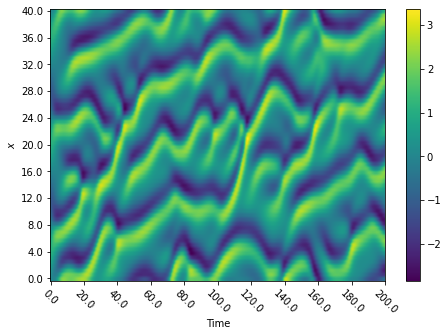

In [24]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [25]:
# making relevant helper arrays to cut off initial transient
initial_t0 = np.array([10])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = (initial_t0[i] + 0.25*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    begin_idx = boundary_idx_arr[i]
    len_relevant_idx += begin_idx - initial_idx[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [26]:
# cutting off initial transient
all_data = all_data[relevant_idx]
init_idx = 0
for i in range(len(boundary_idx_arr)):
    init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
    boundary_idx_arr[i] -= init_idx

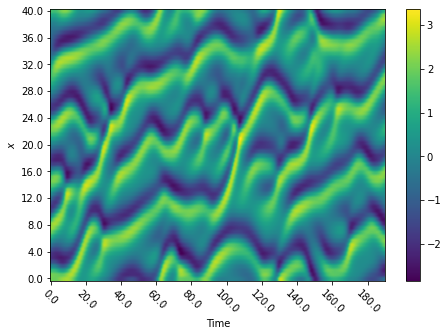

In [27]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [28]:
# saving the data
np.savez(
    dir_name_data+dir_sep+'data',
    all_data=all_data,
    boundary_idx_arr=boundary_idx_arr,
    normalization_constant_arr=[normalization_constant_arr],
    initial_t0=initial_t0
    )

In [29]:
fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)

In [30]:
fl.files

['all_data', 'boundary_idx_arr', 'normalization_constant_arr', 'initial_t0']